<a href="https://colab.research.google.com/github/DisableMan/Flowers-Image-Classification/blob/main/FIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import cv2 
import pickle
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/gdrive', force_remount=True)
local_zip  ='/content/gdrive/My Drive/FIC/Data/Train.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('')
zip_ref.close()

dataDirectory = 'Train/'

In [ ]:
dataPath = dataDirectory
print(os.listdir(dataPath))

['tulip', 'california poppy', 'calendula', 'black-eyed susan', 'bellflower', 'astilbe']


In [ ]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1,
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.1,
)

train_generator = training_datagen.flow_from_directory(
    dataDirectory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    dataDirectory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=42
)

Found 4680 images belonging to 6 classes.
Found 518 images belonging to 6 classes.


In [ ]:
from tqdm import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(train_generator.n/32))): 
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)




In [ ]:
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(validation_generator.n/32))): 
  img, label = next(validation_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 16/16 [00:01<00:00, 10.29it/s]

(518, 224, 224, 3) (518, 6)


In [ ]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, pooling="max" ,weights="imagenet",input_shape=(224,224,3))

x = Flatten()(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(512,activation='relu')(x)
predictions = Dense(6,activation='softmax',name='predictions')(predictions)

base_model.trainable = False
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', patience=5, restore_best_weights = True)
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=[es])

Epoch 1/50
147/147 [==============================] - 83s 564ms/step - loss: 0.6333 - accuracy: 0.7778 - val_loss: 0.5454 - val_accuracy: 0.8069
Epoch 2/50
147/147 [==============================] - 80s 546ms/step - loss: 0.5039 - accuracy: 0.8301 - val_loss: 0.4757 - val_accuracy: 0.8456
Epoch 3/50
147/147 [==============================] - 80s 542ms/step - loss: 0.4667 - accuracy: 0.8338 - val_loss: 0.4459 - val_accuracy: 0.8571
Epoch 4/50
147/147 [==============================] - 81s 547ms/step - loss: 0.4557 - accuracy: 0.8355 - val_loss: 0.4328 - val_accuracy: 0.8552
Epoch 5/50
147/147 [==============================] - 80s 546ms/step - loss: 0.4064 - accuracy: 0.8553 - val_loss: 0.4515 - val_accuracy: 0.8475
Epoch 6/50
147/147 [==============================] - 80s 544ms/step - loss: 0.4105 - accuracy: 0.8590 - val_loss: 0.4625 - val_accuracy: 0.8552
Epoch 7/50
147/147 [==============================] - 80s 543ms/step - loss: 0.3802 - accuracy: 0.8652 - val_loss: 0.4610 - val_ac

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

NameError: ignored

In [ ]:
model.evaluate(X_test, y_test, verbose=1)
validation_generator.class_indices

17/17 [==============================] - 5s 285ms/step - loss: 0.4224 - accuracy: 0.8822


{'astilbe': 0,
 'bellflower': 1,
 'black-eyed susan': 2,
 'calendula': 3,
 'california poppy': 4,
 'tulip': 5}

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving Campanula_persicifolia_Tehumardi_Saaremaa.jpg to Campanula_persicifolia_Tehumardi_Saaremaa.jpg
Campanula_persicifolia_Tehumardi_Saaremaa.jpg
[[0. 1. 0. 0. 0. 0.]]


In [ ]:
categories = ['astilbe','bellflower','black-eyed susan','calendula', 'california poppy','tulip']
print(categories)

['astilbe', 'bellflower', 'black-eyed susan', 'calendula', 'california poppy', 'tulip']


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test,axis=1)

print(classification_report(y_true,y_pred, target_names=categories))

                  precision    recall  f1-score   support

         astilbe       0.82      0.93      0.87        67
      bellflower       0.81      0.84      0.82        79
black-eyed susan       0.99      0.97      0.98        91
       calendula       0.81      0.81      0.81        94
california poppy       0.92      0.78      0.85        92
           tulip       0.93      0.98      0.95        95

        accuracy                           0.88       518
       macro avg       0.88      0.88      0.88       518
    weighted avg       0.88      0.88      0.88       518



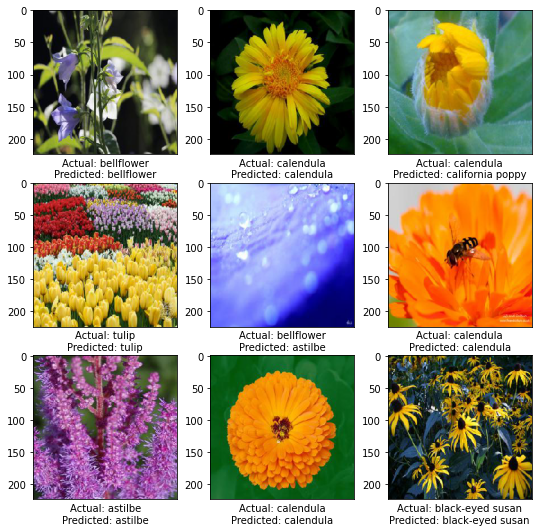

In [ ]:
# prediction = model.predict(X_test)
# prediction = np.argmax(prediction,axis=1)
# labels = (validation_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# print(labels)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# print(labels)
# y_pred= [labels[k] for k in prediction]

# y_true= [labels[k] for k in validation_generator.classes]


plt.figure(figsize=(9,9))

for i in range (9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.xlabel('Actual: '+ categories[y_true[i]] + '\n' +'Predicted: '+ categories[y_pred[i]])

    plt.xticks([])

plt.show()